Drishti
TASK-0

#### We have four cuisine choices for determining the demand for a certain dish in the near future using regression. This has not been implemented, thus we cannot forecast the demand for a certain dish depending on the day, date, weather, or time. whether it's a festival or a traffic congestion There are various options depending on whether it is chilly or hot outdoors, if it is raining or if it is going to be dry. We must maintain watch of everything with human tendencies and ways of thinking.

This code just provides the data visualisation; the model has not yet been developed;and this data and problem statement are based on a challenge. "Your customer is a food delivery service that has locations in several cities. In these cities, they operate a number of fulfilment centres where they ship meal ordersto clients. The customer wants you to assist these facilities with demand forecasts for the following weeks so that they may arrange their raw material inventories properly."

##### The dataset is divided into three different datasheets: the first provides historical demand data for all centres, the second contains information about each fulfilment facility, and the third contains meal information.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

##### Libraries Used
numpy,pandas, scikit learn, matplotlib, seaborn

Weekly Demand data (train.csv): Contains the historical demand data for all centers, test.csv contains all the following features except the target variable
Variable Definition
id Unique ID
week Week No
center_id Unique ID for fulfillment center
meal_id Unique ID for Meal
checkout_price Final price including discount, taxes & delivery charges
base_price Base price of the meal
emailer_for_promotion Emailer sent for promotion of meal
homepage_featured Meal featured at homepage
num_orders (Target) Orders Count


fulfilment_center_info.csv: Contains information for each fulfilment center
Variable Definition
center_id Unique ID for fulfillment center
city_code Unique code for city
region_code Unique code for region
center_type Anonymized center type
op_area Area of operation (in km^2)


meal_info.csv: Contains information for each meal being served
Variable Definition
meal_id Unique ID for the meal
category Type of meal (beverages/snacks/soupsâ€¦.)
cuisine Meal cuisine (Indian/Italian/â€¦)

In [13]:
target = 'num_orders'
#the target for us to find what will be and can be ordered in the near future. 

features = ['center_id', 'meal_id', 'checkout_price', 'mean_base_price', 'discount', 'emailer_for_promotion', 
            'homepage_featured', 'city_code', 'center_type', 'category', 'year', 'region_code', 'month', 
            'week_in_month', 'cuisine', 'average_orders_26week_adj', 'average_orders_52week', 
            'average_orders_26week', 'average_orders_26week_adj_across', 'average_orders_26week_across']

categorical_columns = ['week', 'center_id', 'meal_id', 'emailer_for_promotion', 'homepage_featured', 
                       'city_code', 'region_code', 'center_type', 'category', 'cuisine', 'year', 'month', 'quarter', 
                       'week_in_month']

encoded_columns = ['center_id_55', 'meal_id_1885', 'emailer_for_promotion_0', 'homepage_featured_0', 'city_code_647', 
                   'region_code_56', 'center_type_TYPE_C', 'category_Beverages', 'cuisine_Italian', 'year_3', 
                   'month_1', 'week_in_month_2']

In [16]:
orders = pd.read_csv("C:\\Users\\KIIT\\Desktop\\FeynnLabs\\TASK0\\DataSet\\train.csv", index_col='id').fillna(0)
orders.head()

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
id,,,,,,,,
1379560,1,55,1885,136.83,152.29,0,0,177
1466964,1,55,1993,136.83,135.83,0,0,270
1346989,1,55,2539,134.86,135.86,0,0,189
1338232,1,55,2139,339.50,437.53,0,0,54
1448490,1,55,2631,243.50,242.50,0,0,40


In [17]:
meal_info = pd.read_csv("C:\\Users\\KIIT\\Desktop\\FeynnLabs\\TASK0\DataSet\\meal_info.csv", index_col='meal_id').fillna(0)
meal_info.head()

,category,cuisine
meal_id,,
1885,Beverages,Thai
1993,Beverages,Thai
2539,Beverages,Thai
1248,Beverages,Indian
2631,Beverages,Indian


In [18]:
fulfillment = pd.read_csv("C:\\Users\\KIIT\\Desktop\\FeynnLabs\\TASK0\\DataSet\\fulfilment_center_info.csv", index_col='center_id').fillna(0)
fulfillment.head()

,city_code,region_code,center_type,op_area
center_id,,,,
11,679,56,TYPE_A,3.7
13,590,56,TYPE_B,6.7
124,590,56,TYPE_C,4.0
66,648,34,TYPE_A,4.1
94,632,34,TYPE_C,3.6


##### Data preprocessing 
Data cleaning 
In any of the three datasets, there are no Missing/Null Values.
Before beginning the prediction procedure, all three datasheets must be combined into a single dataset. The major feature for combining the datasets must be checked prior to starting the merging procedure. The number of Center IDs in the train dataset matches the number of Center IDs in the Centers Dataset, which is 77 unique entries. As a result, there will be no missing values when the datasets are combined. The number of Meal IDs in the train dataset matches the number of Meal IDs in the Meals Dataset, which is 51 distinct entries. As a result, there will be no missing values when the datasets are combined. As checked earlier, there were no Null/Missing values even after merging the datasets.

In [19]:
orders_meal = pd.merge(orders, fulfillment, on='center_id', how='left')

In [20]:
orders_full = pd.merge(orders_meal, meal_info, on='meal_id', how='left')

In [15]:
orders_full.head()

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1,55,1993,136.83,135.83,0,0,270,647,56,TYPE_C,2.0,Beverages,Thai
2,1,55,2539,134.86,135.86,0,0,189,647,56,TYPE_C,2.0,Beverages,Thai
3,1,55,2139,339.50,437.53,0,0,54,647,56,TYPE_C,2.0,Beverages,Indian
4,1,55,2631,243.50,242.50,0,0,40,647,56,TYPE_C,2.0,Beverages,Indian


In [135]:
orders_full.to_csv("fulldata.csv")

In [136]:
orders_full.describe()

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,op_area
count,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.00000,456548.000000,456548.000000,456548.000000,456548.000000
mean,74.768771,82.105796,2024.337458,332.238933,354.156627,0.081152,0.10920,261.872760,601.553399,56.614566,4.083590
std,41.524956,45.975046,547.420920,152.939723,160.715914,0.273069,0.31189,395.922798,66.195914,17.641306,1.091686
min,1.000000,10.000000,1062.000000,2.970000,55.350000,0.000000,0.00000,13.000000,456.000000,23.000000,0.900000
25%,39.000000,43.000000,1558.000000,228.950000,243.500000,0.000000,0.00000,54.000000,553.000000,34.000000,3.600000
50%,76.000000,76.000000,1993.000000,296.820000,310.460000,0.000000,0.00000,136.000000,596.000000,56.000000,4.000000
75%,111.000000,110.000000,2539.000000,445.230000,458.870000,0.000000,0.00000,324.000000,651.000000,77.000000,4.500000
max,145.000000,186.000000,2956.000000,866.270000,866.270000,1.000000,1.00000,24299.000000,713.000000,93.000000,7.000000


In [16]:
import seaborn as sns
from matplotlib import pyplot as plt

<AxesSubplot:xlabel='week', ylabel='num_orders'>

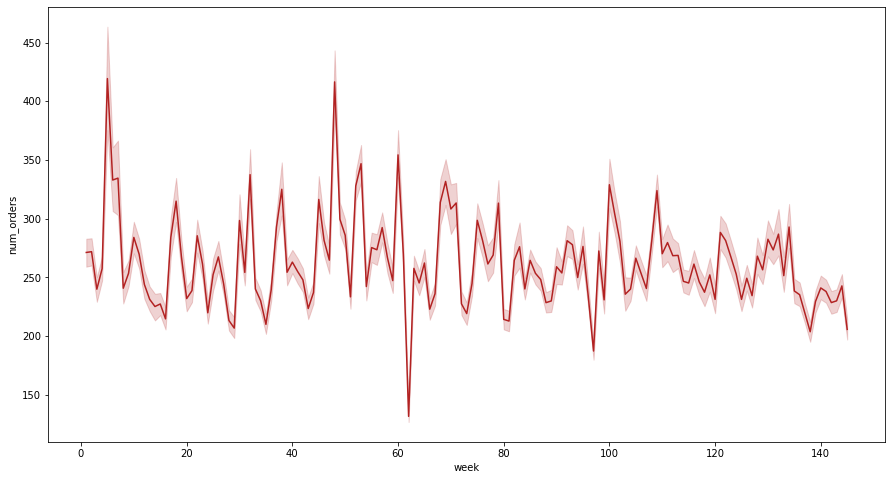

In [27]:
plt.figure(figsize=(15,8))
sns.lineplot(orders_full['week'],orders_full['num_orders'],color='firebrick')

Peak sales occurred in the fifth and fifty-first weeks.
The 62nd week saw a significant drop in sales.

<AxesSubplot:title={'center':'Center type'}>

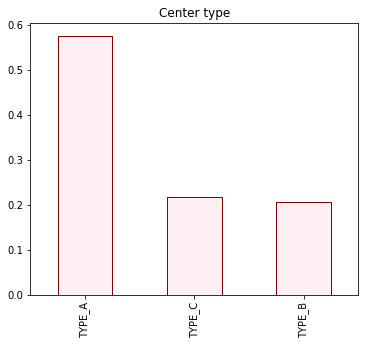

In [28]:
plt.figure(1)
plt.subplot(133)
orders_full['center_type'].value_counts(normalize = True).plot.bar(figsize = (20,5), color=('lavenderblush'),  edgecolor='maroon', title = 'Center type')

Center type A is in high demand and sells well.
Surprisingly, Center Type C outperforms Center Type B.

<AxesSubplot:title={'center':'Cuisine'}>

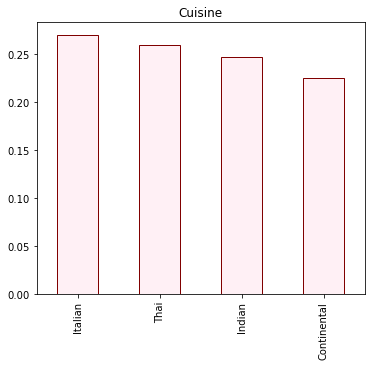

In [29]:
plt.figure(1)
plt.subplot(132)
orders_full['cuisine'].value_counts(normalize=True).plot.bar(figsize = (20,5),color=('lavenderblush'),  edgecolor='maroon', title = "Cuisine")

Italian cuisine outsells Indian cuisine in terms of sales.

<AxesSubplot:title={'center':'Category'}>

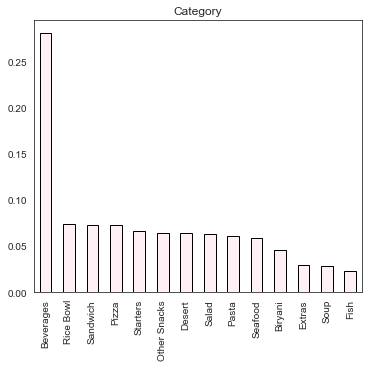

In [154]:
plt.figure(1)
plt.subplot(131)
orders_full['category'].value_counts(normalize = True).plot.bar(figsize = (20,5),color=('lavenderblush'),  edgecolor='black', title = 'Category')

Bevareges is a popular item

<AxesSubplot:title={'center':'Region wise'}>

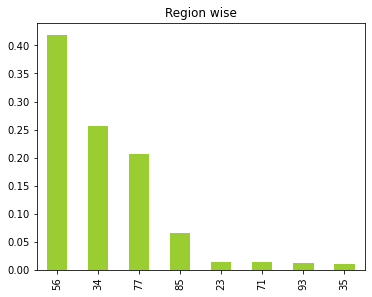

In [25]:
#Plotting distribution for Region_wise/Center wise
plt.figure(1)
plt.subplot(231)
orders_full['region_code'].value_counts(normalize = True).plot.bar(figsize = (20,10), color='yellowgreen' ,title = 'Region wise')

To get Italian cuisine and understand the distribution
Data distribution of Italian cuisine

<AxesSubplot:xlabel='category'>

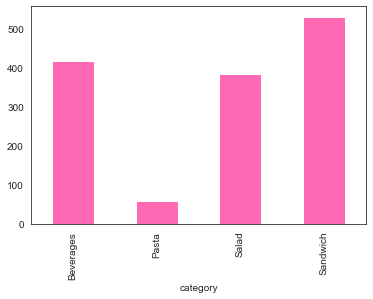

In [100]:
italian_cuisine = orders_full[orders_full['cuisine'] == 'Italian']
italian_cuisine.groupby('category')['num_orders'].mean().plot.bar(color= 'hotpink')

Surprisingly, Italian cusine has more sales of Sandwitch than Pasta
Pasta is not demanding item.
Salad has good demand.

To get Indian cuisine and understand the distribution
Data distribution of Indian cuisine

<AxesSubplot:xlabel='category'>

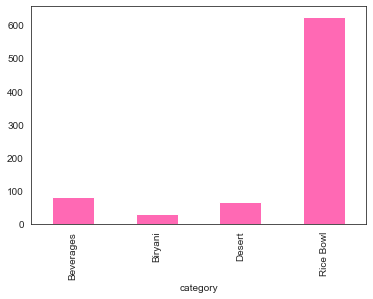

In [102]:

indian_cuisine = orders_full[orders_full['cuisine'] == 'Indian']

indian_cuisine.groupby('category')['num_orders'].mean().plot.bar(color='hotpink')



Rice Bowl is obvious option.
Biryani is not preferred option from client business.

To get Thai cuisine and understand the distribution
Data distribution of Thai cuisine

<AxesSubplot:xlabel='category'>

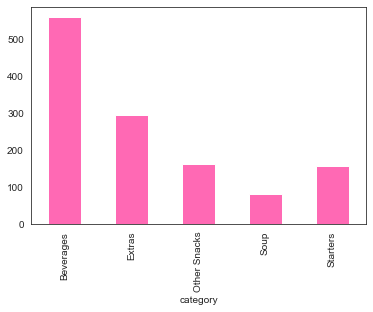

In [103]:
Thai_cuisine = orders_full[orders_full['cuisine'] == 'Thai']
Thai_cuisine.groupby('category')['num_orders'].mean().plot.bar(color='hotpink')

Beverages is preferred food in Thai cuisine.
Other snacks is major contributor in overall sales.

To get Continental cuisine and understand the distribution
Data distribution of Continental cuisine

<AxesSubplot:xlabel='category'>

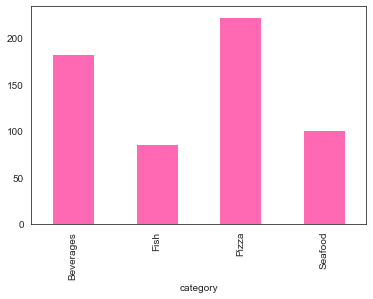

In [104]:
Continental_cuisine = orders_full[orders_full['cuisine'] == 'Continental']
Continental_cuisine.groupby('category')['num_orders'].mean().plot.bar(color='hotpink')

Pizza is highly demanding food in Continental cuisine.
Beverages and seafood also has good demand.

In [ ]:
fig=plt.figure(figsize=(18,8))
sns.set_style("white")
plt.xticks(rotation=90,fontsize=12)
plt.title('Total Number of Orders for Each Cuisine-Category',fontdict={'fontsize':14})

sns.barplot(x='category',y='num_orders',orders_full=orders_full.groupby(['cuisine','category']).sum().sort_values(by='num_orders', ascending=False).reset_index(),hue='cuisine',palette='YlOrRd_r')

plt.ylabel('No. of Orders',fontdict={'fontsize':12})
plt.xlabel('Cuisine-Category',fontdict={'fontsize':12})
sns.despine(bottom = True, left = True);

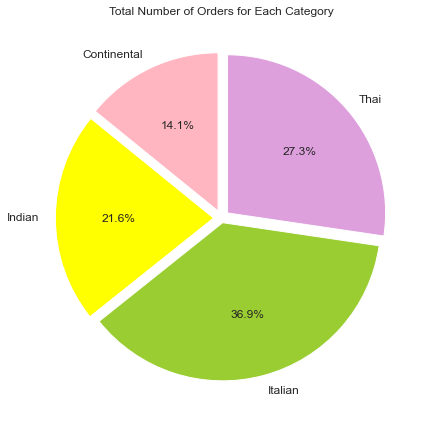

In [101]:
plt.figure(figsize=(6,6))
colors = ['lightpink','yellow','yellowgreen','plum']
plt.pie(orders_full.groupby(['cuisine']).num_orders.sum(),
    labels=orders_full.groupby(['cuisine']).num_orders.sum().index,
    shadow=False,
    colors=colors,
    explode=(0.05, 0.05, 0.03,0.05),
    startangle=90, 
    autopct='%1.1f%%',pctdistance=0.6,
    textprops={'fontsize': 12})
plt.title('Total Number of Orders for Each Category')
plt.tight_layout()
plt.show()

In [47]:
#Creating date attribute - To use Time series models
df_sr = pd.Series(pd.date_range(start='2001-01-01', periods=len(order_data_66_1885), freq='W'))

In [48]:
#Creating weekly sequence data
re = df_sr.dt.week

In [49]:
#To view sequence data
re

0       1
1       2
2       3
3       4
4       5
       ..
140    37
141    38
142    39
143    40
144    41
Length: 145, dtype: int64

In [50]:
#To concat date attribute with sequence data
new = pd.concat([df_sr,re], axis=1)

In [51]:
#To rename index with proper column name - date and week component 
new_data = new.rename(columns = {0:"ds", 1:"week"})

In [52]:
#To view after renaming
new_data.head(3)

,ds,week
0,2001-01-07,1
1,2001-01-14,2
2,2001-01-21,3


In [53]:
#To merge date attribute with data set
timeseries_data = pd.merge(new_data,order_data_66_1885, how = 'left', on = 'week')

In [54]:
#To view after merging
timeseries_data.head(3)

,ds,week,meal_id,num_orders,center_id
0,2001-01-07,1,1885,674,66
1,2001-01-14,2,1885,1027,66
2,2001-01-21,3,1885,863,66


# Time series Model Building

In [55]:
#Importing statsmodel Library - which helps in time series
import statsmodels.api as sm

C:\Users\Lokesh\AppData\Roaming\Python\Python37\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


### Decompose the timeseries

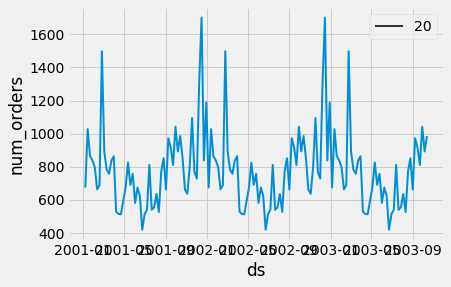

In [56]:
#To view distribution of order details with time frame
sns.lineplot(x="ds", y="num_orders",legend = 'full' , data=timeseries_data, size=20)

<Figure size 432x288 with 0 Axes>

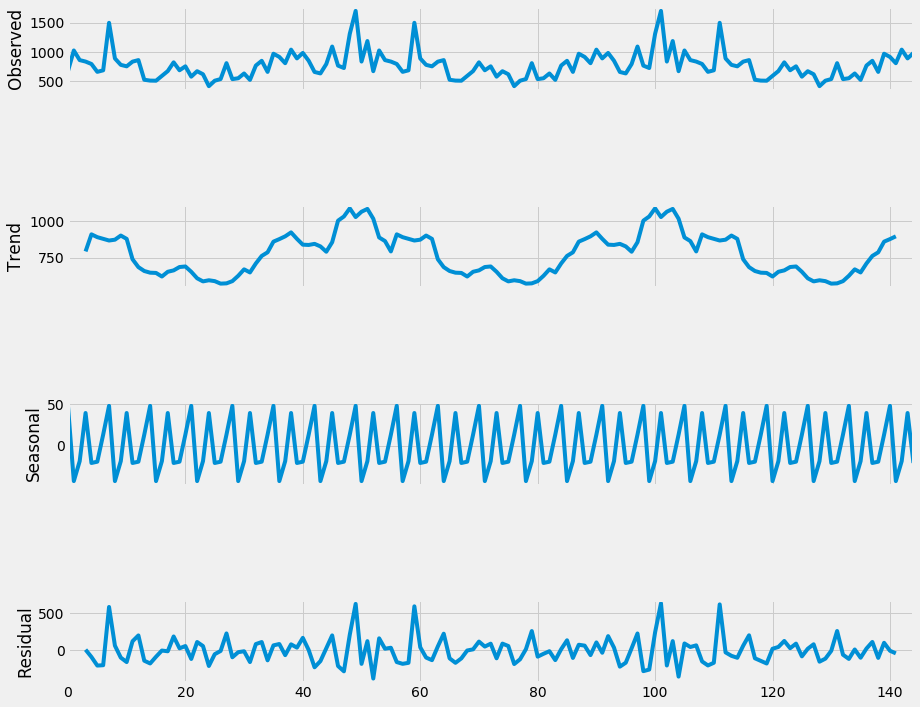

In [57]:
#Decompose the time series data
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(timeseries_data['num_orders'], model = 'additive', freq=7)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

In [58]:
#Creating function for ploting stationarity

from statsmodels.tsa.stattools import adfuller
    
def test_stationarity(timeseries, window = 12, cutoff = 0.01):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

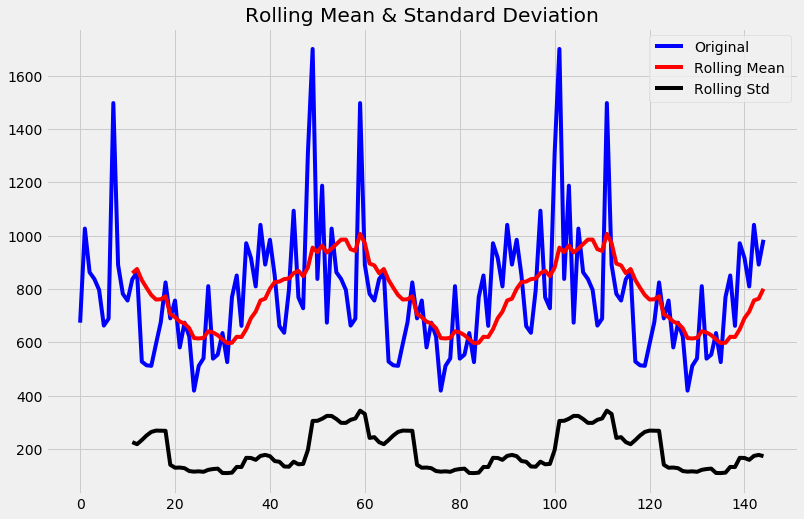

Results of Dickey-Fuller Test:
p-value = 0.0001. The series is likely stationary.
Test Statistic                  -4.779507
p-value                          0.000060
#Lags Used                      20.000000
Number of Observations Used    124.000000
Critical Value (1%)             -3.484220
Critical Value (5%)             -2.885145
Critical Value (10%)            -2.579359
dtype: float64


In [59]:
#Calling stationarity function
test_stationarity(timeseries_data['num_orders'])

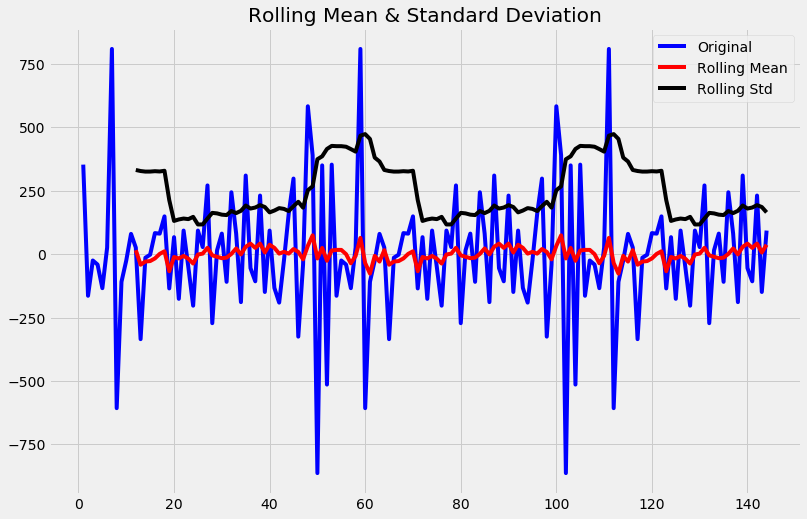

Results of Dickey-Fuller Test:
p-value = 0.0504. The series is likely non-stationary.
Test Statistic                  -2.858159
p-value                          0.050434
#Lags Used                      12.000000
Number of Observations Used    131.000000
Critical Value (1%)             -3.481282
Critical Value (5%)             -2.883868
Critical Value (10%)            -2.578677
dtype: float64


In [60]:
#Doing first order difference

first_diff = timeseries_data.num_orders - timeseries_data.num_orders.shift(1)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff)

C:\Users\Lokesh\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


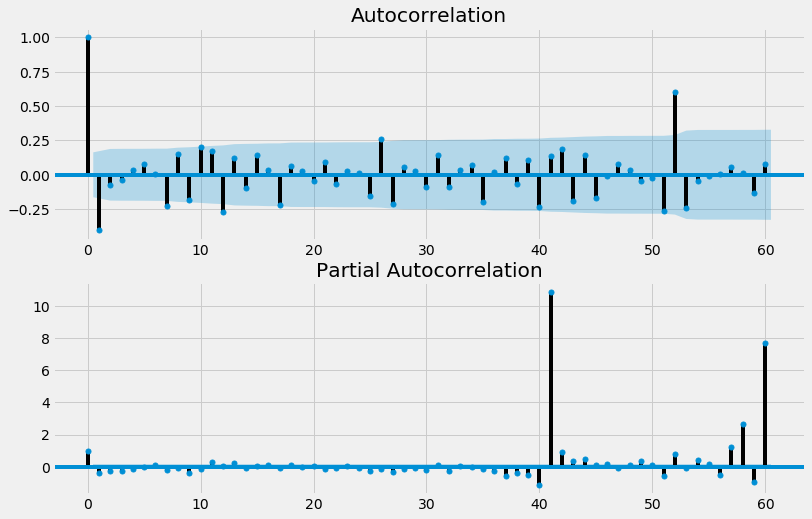

In [61]:
#Plotting ACF, PACF plot  - Differenced data

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=60, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=60, ax=ax2)# 

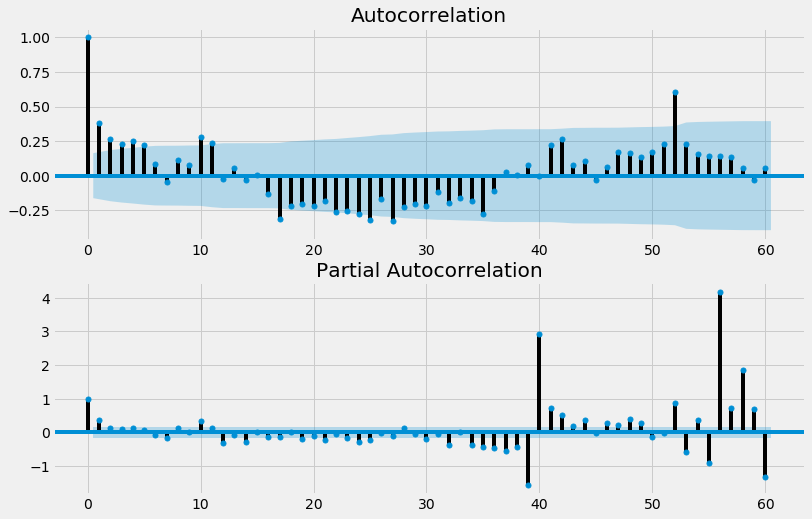

In [62]:
#Plotting ACF, PACF plot  - Original data
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(timeseries_data.num_orders, lags=60, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(timeseries_data.num_orders, lags=60, ax=ax2)# 

In [63]:
#Building ARIMA model
arima_mod6 = sm.tsa.ARIMA(timeseries_data.num_orders, (6,1,0)).fit(disp=False)
print(arima_mod6.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.num_orders   No. Observations:                  144
Model:                 ARIMA(6, 1, 0)   Log Likelihood                -978.894
Method:                       css-mle   S.D. of innovations            216.299
Date:                Thu, 28 Nov 2019   AIC                           1973.789
Time:                        12:36:13   BIC                           1997.547
Sample:                             1   HQIC                          1983.443
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.8861      7.618      0.116      0.908     -14.045      15.817
ar.L1.D.num_orders    -0.6268      0.083     -7.532      0.000      -0.790      -0.464
ar.L2.D.num_orders  

In [64]:
#Train Test split
train = timeseries_data[:130]
val = timeseries_data[130:]

In [65]:
#Finding shape of train and validation data set
print(train.shape)
print(val.shape)

(130, 5)
(15, 5)


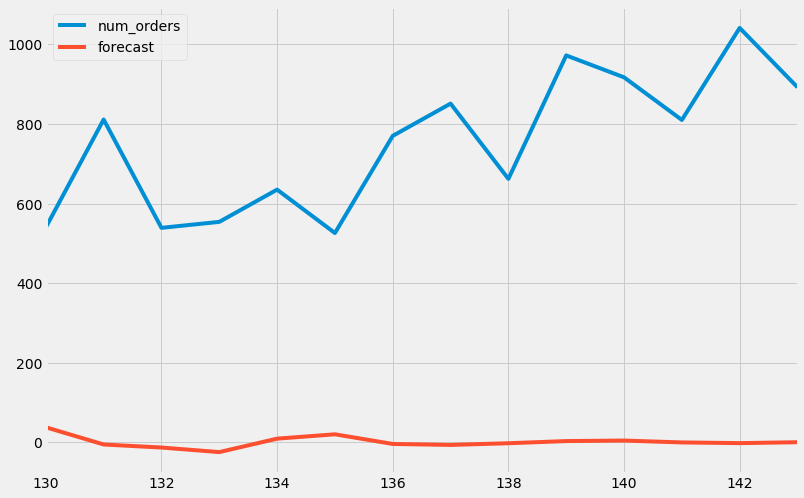

In [66]:
#Forecasting on Validation Data set
start_index = 130
end_index = 144
timeseries_data['forecast'] = arima_mod6.predict(start = start_index, end= end_index, dynamic= True)  
timeseries_data[start_index:end_index][['num_orders', 'forecast']].plot(figsize=(12, 8))

### The difference between Actual and forecast is high

## Analyze the result

NormaltestResult(statistic=35.80168382154622, pvalue=1.681756584494126e-08)


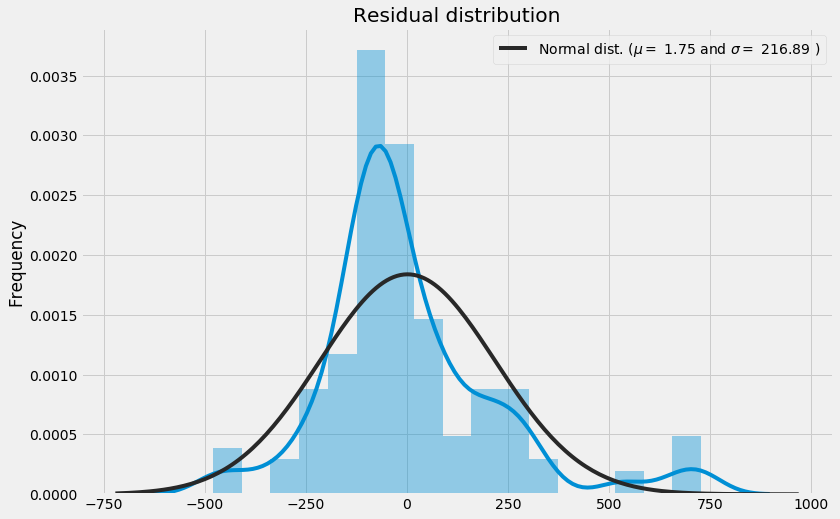

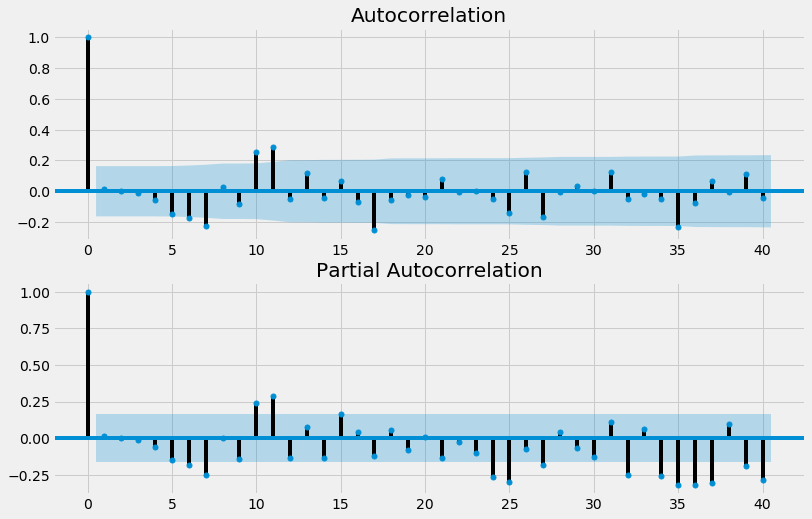

In [67]:
from scipy import stats
from scipy.stats import normaltest

resid = arima_mod6.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')

plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod6.resid, lags=40, ax=ax2)

## Observation:

The graph looks very like a normal distribution. But it failed the P value test. 

Also we see a recurring correlation exists in both ACF and PACF. So we need to deal with seasonality

In [220]:
#Defining date for future forecast
start_index = 2003-10-19
end_index = 2003-12-9

In [230]:
#Forecasting on furture 10 weeks 
Arima_forecast = arima_mod6.forecast(10)

In [231]:
Arima_forecast

(array([959.5674833 , 944.13780566, 960.0490601 , 966.08670933,
        958.26259123, 965.14208339, 960.15911622, 963.56505967,
        966.13053254, 965.85356049]),
 array([216.29899021, 230.86790489, 240.25039446, 250.68713961,
        266.75785676, 287.59706981, 303.76982951, 313.85846752,
        325.73110463, 338.76919631]),
 array([[ 535.62925259, 1383.505714  ],
        [ 491.64502688, 1396.63058444],
        [ 489.16693968, 1430.93118051],
        [ 474.74894431, 1457.42447436],
        [ 435.42679938, 1481.09838308],
        [ 401.46218449, 1528.82198228],
        [ 364.7811908 , 1555.53704165],
        [ 348.41376709, 1578.71635226],
        [ 327.70929883, 1604.55176626],
        [ 301.87813665, 1629.82898434]]))

In [232]:
Arima_output = [959.5674833 , 944.13780566, 960.0490601 , 966.08670933,
        958.26259123, 965.14208339, 960.15911622, 963.56505967,
        966.13053254, 965.85356049]

In [267]:
Arima_output = pd.DataFrame(Arima_output)

Text(0.5, 1.0, 'Forecast for next 10 weeks')

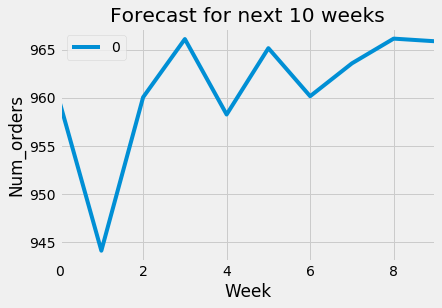

In [269]:
Arima_output.plot()
plt.xlabel('Week')
plt.ylabel('Num_orders')
plt.title('Forecast for next 10 weeks')

## Handling seasonality by SARIMA model

In [68]:
sarima_mod6 = sm.tsa.statespace.SARIMAX(timeseries_data.num_orders, trend='n', order=(1,1,1), seasonal_order=(1, 0, 0, 52),  initialization='approximate_diffuse').fit()
print(sarima_mod6.summary())

C:\Users\Lokesh\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


                                 Statespace Model Results                                 
Dep. Variable:                         num_orders   No. Observations:                  145
Model:             SARIMAX(1, 1, 1)x(1, 0, 0, 52)   Log Likelihood                 275.161
Date:                            Thu, 28 Nov 2019   AIC                           -542.321
Time:                                    12:36:30   BIC                           -530.442
Sample:                                         0   HQIC                          -537.494
                                            - 145                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0000      0.040    -25.155      0.000      -1.078      -0.922
ma.L1          1.0000   3.85e-08   

### Analysis the residuls

NormaltestResult(statistic=57.83685690823973, pvalue=2.7598539310687054e-13)


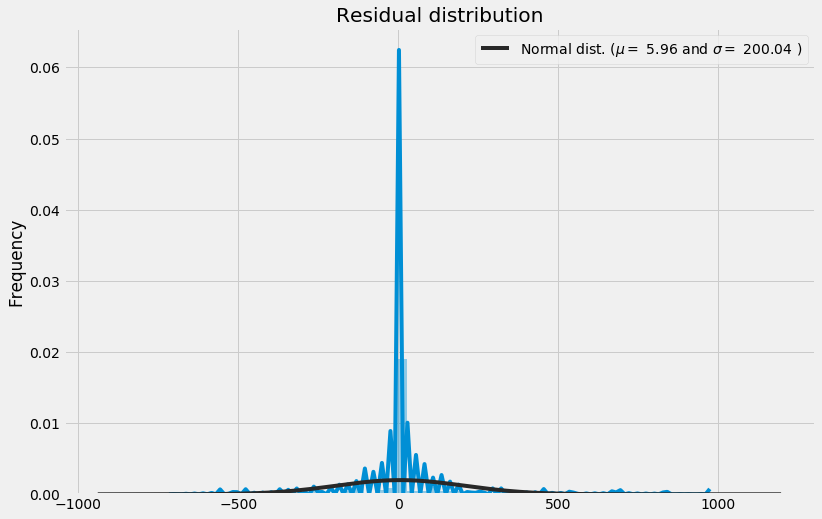

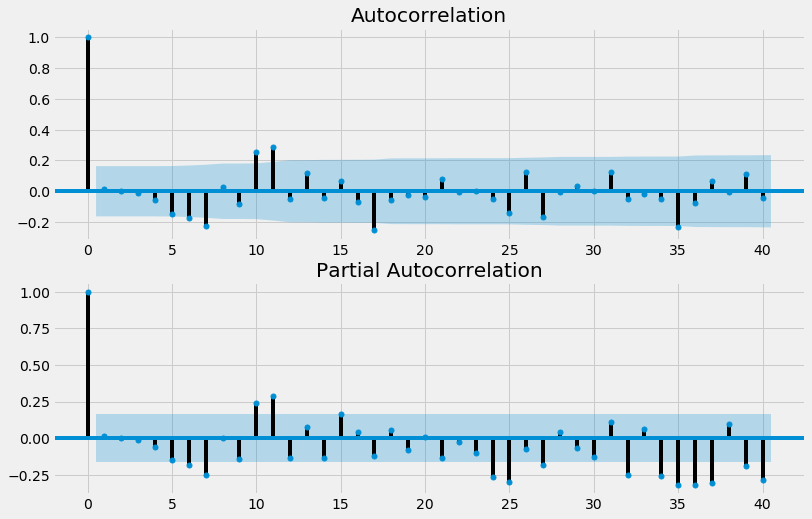

In [69]:
resid = sarima_mod6.resid
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod6.resid, lags=40, ax=ax2)


## Prediction with SARIMA model

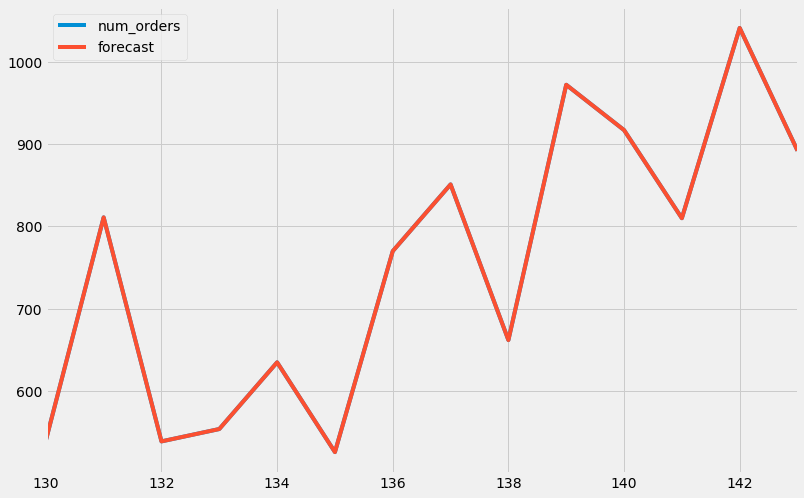

In [70]:
start_index = 130
end_index = 144
timeseries_data['forecast'] = sarima_mod6.predict(start = start_index, end= end_index, dynamic= True)  
timeseries_data[start_index:end_index][['num_orders', 'forecast']].plot(figsize=(12, 8))

## Observation: 

1. Y-actual(validation Dataset) and forecasted values are same. 

2. Data points are exactly overlapping. 

In [71]:
#Function to find MAPE
def smape_mape(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")

In [72]:
#Finding MAPE for validation dataset
smape_mape(timeseries_data[130:144]['num_orders'],timeseries_data[130:144]['forecast'])

MAPE: 0.00 % 
SMAPE: 0.00 %


In [73]:
#Defining date for future forecast
start_index = 2003-10-19
end_index = 2003-12-9

In [74]:
#Forecasting on furture 10 weeks 
sarima_mod6.forecast(steps = 10,exog = timeseries_data[start_index:end_index])

C:\Users\Lokesh\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:1935: ValueWarning: Exogenous array provided to predict, but additional data not required. `exog` argument ignored.
  ' required. `exog` argument ignored.', ValueWarning)


145     852.000048
146     661.000153
147     636.000150
148     796.000089
149    1093.999934
150     769.000102
151     728.000107
152    1310.999846
153    1700.999648
154     838.000069
dtype: float64

In [254]:
Sarima_forecast = sarima_mod6.forecast(steps = 10,exog = timeseries_data[start_index:end_index])

C:\Users\Lokesh\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:1935: ValueWarning: Exogenous array provided to predict, but additional data not required. `exog` argument ignored.
  ' required. `exog` argument ignored.', ValueWarning)


In [255]:
Sarima_forecast = pd.DataFrame(Sarima_forecast)

In [260]:
Sarima_forecast.rename(columns={0:"Num_orders"})

,Num_orders
145,852.000048
146,661.000153
147,636.000150
148,796.000089
149,1093.999934
150,769.000102
151,728.000107
152,1310.999846
153,1700.999648
154,838.000069


Text(0.5, 1.0, 'Forecast for next 10 weeks')

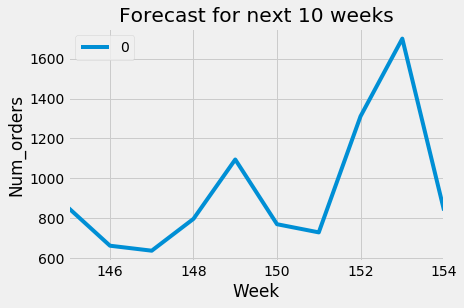

In [266]:
Sarima_forecast.plot()
plt.xlabel('Week')
plt.ylabel('Num_orders')
plt.title('Forecast for next 10 weeks')

### SARIMA Model insights
Number of orders are in between 660 to 1200 as per validation forecast 

But as per SARIMA model prediction the number of orders are between 660 to 1700 for future dates.

Only num_orders variable is used to build SARIMA Model so prediction may not be accurate.
